In [1]:
# All imports
from __future__ import print_function
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt

import os
import pickle
import numpy as np
import h5py

Using TensorFlow backend.


In [2]:
# Preparing data for training and testing NN
num_classes = 100
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar100.h5'
print(save_dir)

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

epochs = 1
data_augmentation = True
num_predictions = 20
batch_size = 64
validations = []

/content/saved_models
169009152/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# Model creation
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.15))

model.add(Conv2D(192, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(192, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.15))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
# Training model
if not data_augmentation:
    print('Not using data augmentation.')
else:
    print('Using real-time data augmentation.')    
for i in range(epochs):
    if not data_augmentation:
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    else:
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=1,
                            validation_data=(x_test, y_test))
        validations.append(model.evaluate_generator(datagen.flow(x_test, y_test,
                                          batch_size=batch_size),
                                          steps=x_test.shape[0] // batch_size))

pickle.dump(validations, open("loss_validation.p",'wb'))

Using real-time data augmentation.
Epoch 1/1
781/781 [==============================] - 47s 60ms/step - loss: 1.2615 - acc: 0.6494 - val_loss: 1.4905 - val_acc: 0.6067


In [0]:
# Predictions of model
label_list_path = 'datasets/cifar-100-python/meta'

keras_dir = os.path.expanduser(os.path.join('~', '.keras'))
datadir_base = os.path.expanduser(keras_dir)
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
label_list_path = os.path.join(datadir_base, label_list_path)

with open(label_list_path, mode='rb') as f:
    labels = pickle.load(f)

# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

print('Model Accuracy = %.2f' % (evaluation[1]))

predict_gen = model.predict_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

for predict_index, predicted_y in enumerate(predict_gen):
    actual_label = labels['fine_label_names'][np.argmax(y_test[predict_index])]
    predicted_label = labels['fine_label_names'][np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    if predict_index == num_predictions:
        break

Model Accuracy = 0.60
Actual Label = mountain vs. Predicted Label = pear
Actual Label = forest vs. Predicted Label = wardrobe
Actual Label = seal vs. Predicted Label = man
Actual Label = mushroom vs. Predicted Label = keyboard
Actual Label = sea vs. Predicted Label = elephant
Actual Label = tulip vs. Predicted Label = pear
Actual Label = camel vs. Predicted Label = kangaroo
Actual Label = butterfly vs. Predicted Label = woman
Actual Label = cloud vs. Predicted Label = motorcycle
Actual Label = apple vs. Predicted Label = maple_tree
Actual Label = sea vs. Predicted Label = skyscraper
Actual Label = skunk vs. Predicted Label = orchid
Actual Label = streetcar vs. Predicted Label = cloud
Actual Label = rocket vs. Predicted Label = pear
Actual Label = lamp vs. Predicted Label = woman
Actual Label = lion vs. Predicted Label = couch
Actual Label = tulip vs. Predicted Label = cup
Actual Label = wolf vs. Predicted Label = bowl
Actual Label = rose vs. Predicted Label = dolphin
Actual Label = ora

94
94
wardrobe
wardrobe


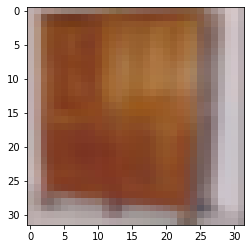

In [0]:
# Some test dump to see how model works
x = np.random.randint(0,len(x_test))
prediction = np.argmax(model.predict(np.array([x_test[x]])))
actual = np.argmax(y_test[x])
print(prediction)
print(actual)
print(labels['fine_label_names'][prediction])
print(labels['fine_label_names'][actual])
plt.imshow(x_test[x])